# This Notebook estimates the model

## Settings

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from time import time
import matplotlib.pyplot as plt
from figure_manager import FigureManager
from plots import *

import DynamicTimeAllocationModel

path = 'output/'

fm = FigureManager(path, use_latex=False)

# c++ settings
do_compile = True
threads = 40

# from EconModel import cpptools
# cpptools.setup_nlopt(folder='cppfuncs/', do_print=True)

In [2]:
# setup model
settings = { 
       'T':30,
       'num_A': 15,
       'num_A_pd': 16,
       'num_K': 12,
       'num_power': 11,
       'num_love': 6,
       
       'max_A': 1_000,
       'max_A_pd': 1_000,
       'max_Ctot': 2_000,
       'max_K': 30,
       
       'init_couple_share': 0.77,
       
       'simT': 30,
       'simN': 10_000,

       'num_Ctot': 120,
       'num_marg_u':120,

       'phi': 1.0,
       'phi_mult': 1.0,
       
       'mu': 2.5,
       'mu_mult': 1.0,
       
       'gamma': 0.14,
       'gamma_mult': 1.0,
       
       'p_meet': 0.0,

       'threads':threads,
       'num_multistart': 2,
       
       'do_egm': True,
       'interp_method': 'linear',
       'interp_inverse': True,
       
       'precompute_intratemporal': True,
       'centered_gradient': True,
       }

model = DynamicTimeAllocationModel.HouseholdModelClass(par=settings) 
model.link_to_cpp(force_compile=do_compile)

## Empirical Moments to Match

In [3]:
# # all moments listed here will be used in estimation. Comment out those you do not want to use.
# datamoms = dict()

# # Wages (Adda et al, 2017, Table 1)
# datamoms['wage_level_w'] = 3.634
# datamoms['wage_level_m'] = 3.634

# datamoms[('wage_growth_w',5)] = 0.0510
# datamoms[('wage_growth_m',5)] = 0.0510

# datamoms[('wage_growth_w',10)] = 0.0208
# datamoms[('wage_growth_m',10)] = 0.0208

# datamoms[('wage_growth_w',15)] = 0.0133
# datamoms[('wage_growth_m',15)] = 0.0133

# # Time allocation (Blundell et al. 2018, Table 1, assuming 5*16*52=4160 annual hours)
# datamoms['time_work_w'] = 1750.0
# datamoms['time_work_m'] = 2074.0

# datamoms['time_leisure_w'] = 2410.0
# datamoms['time_leisure_m'] = 2086.0

# # consumption (Blundell et al. 2018, Table 1)
# datamoms['consumption'] = 42716.0


In [4]:
# all moments listed here will be used in estimation. Comment out those you do not want to use.
datamoms = dict()

# wages
datamoms['wage_level_w_25_34'] = 40.1
datamoms['wage_level_m_25_34'] = 49.3
datamoms['wage_level_w_35_44'] = 50.4
datamoms['wage_level_m_35_44'] = 67.8

# employment rates
datamoms['employment_rate_w_35_44'] = 64.0
datamoms['employment_rate_m_35_44'] = 88.0
datamoms['work_hours_w'] = 1935.0
datamoms['work_hours_m'] = 2285.0

# home production
datamoms['home_prod_w'] = 1434.0
datamoms['home_prod_m'] = 913.0

# consumption
datamoms['consumption'] = 42.716

# marriage and divorce rates
datamoms['marriage_rate_35_44'] = 69.0
datamoms['divorce_rate_35_44'] = 12.0

## Parameters to estimate

In [5]:
# parameters to estimate
estpars = {
    # Wages
    'mu': {'guess':2.5,'lower':1.0,'upper':5.00}, 
    'mu_mult': {'guess':1.0,'lower':0.5,'upper':2.0},
    'gamma': {'guess':0.12,'lower':0.05,'upper':0.20},
    'gamma_mult': {'guess':1.0,'lower':0.5,'upper':2.0},
    
    # Disutility from work
    'eta': {'guess':0.5,'lower':0.1,'upper':2.0},
    'eta_mult': {'guess':1.0,'lower':0.5,'upper':2.0},
    'phi': {'guess':0.7,'lower':0.1,'upper':2.0},
    'phi_mult': {'guess':1.0,'lower':0.5,'upper':2.0},
    
    # Home production
    'alpha': {'guess':1.0,'lower':0.1,'upper':10.0},
    'zeta': {'guess':0.5,'lower':0.1,'upper':2.0},
    'omega': {'guess':0.5,'lower':0.1,'upper':2.0},
    
    # Match quality
    'sigma_love': {'guess':0.15,'lower':0.01,'upper':0.5},
    'div_cost': {'guess':0.0,'lower':0.0,'upper':100.0},
}


In [6]:
# check bounds
bounds_ok = True
for key in estpars.keys():
    if estpars[key]['guess']<estpars[key]['lower']:
        print(key,' lower',estpars[key]['guess'])
        bounds_ok = False
    
    if estpars[key]['guess']>estpars[key]['upper']:
        print(key,' upper',estpars[key]['guess'])
        bounds_ok = False

if not bounds_ok:
    stop

## setup initial guess 

In [7]:
# check initial guess
theta_init = np.array([estpars[key]['guess'] for key in estpars.keys()])
obj_init = model.obj_func(theta_init,estpars, datamoms, do_print=True)

Parameters:
  mu             : 2.5000 (init: 2.5000)
  mu_mult        : 1.0000 (init: 1.0000)
  gamma          : 0.1200 (init: 0.1200)
  gamma_mult     : 1.0000 (init: 1.0000)
  eta            : 0.5000 (init: 0.5000)
  eta_mult       : 1.0000 (init: 1.0000)
  phi            : 0.7000 (init: 0.7000)
  phi_mult       : 1.0000 (init: 1.0000)
  alpha          : 1.0000 (init: 1.0000)
  zeta           : 0.5000 (init: 0.5000)
  omega          : 0.5000 (init: 0.5000)
  sigma_love     : 0.1500 (init: 0.1500)
  div_cost       : 0.0000 (init: 0.0000)
Moments:
  wage_level_w_25_34       : sim: 37.2630, data: 40.1000
  wage_level_m_25_34       : sim: 37.2933, data: 49.3000
  wage_level_w_35_44       : sim: 44.5378, data: 50.4000
  wage_level_m_35_44       : sim: 44.5812, data: 67.8000
  employment_rate_w_35_44  : sim: 88.0597, data: 64.0000
  employment_rate_m_35_44  : sim: 87.5246, data: 88.0000
  work_hours_w             : sim: 2434.1851, data: 1935.0000
  work_hours_m             : sim: 2434.5817

check solution makes sense

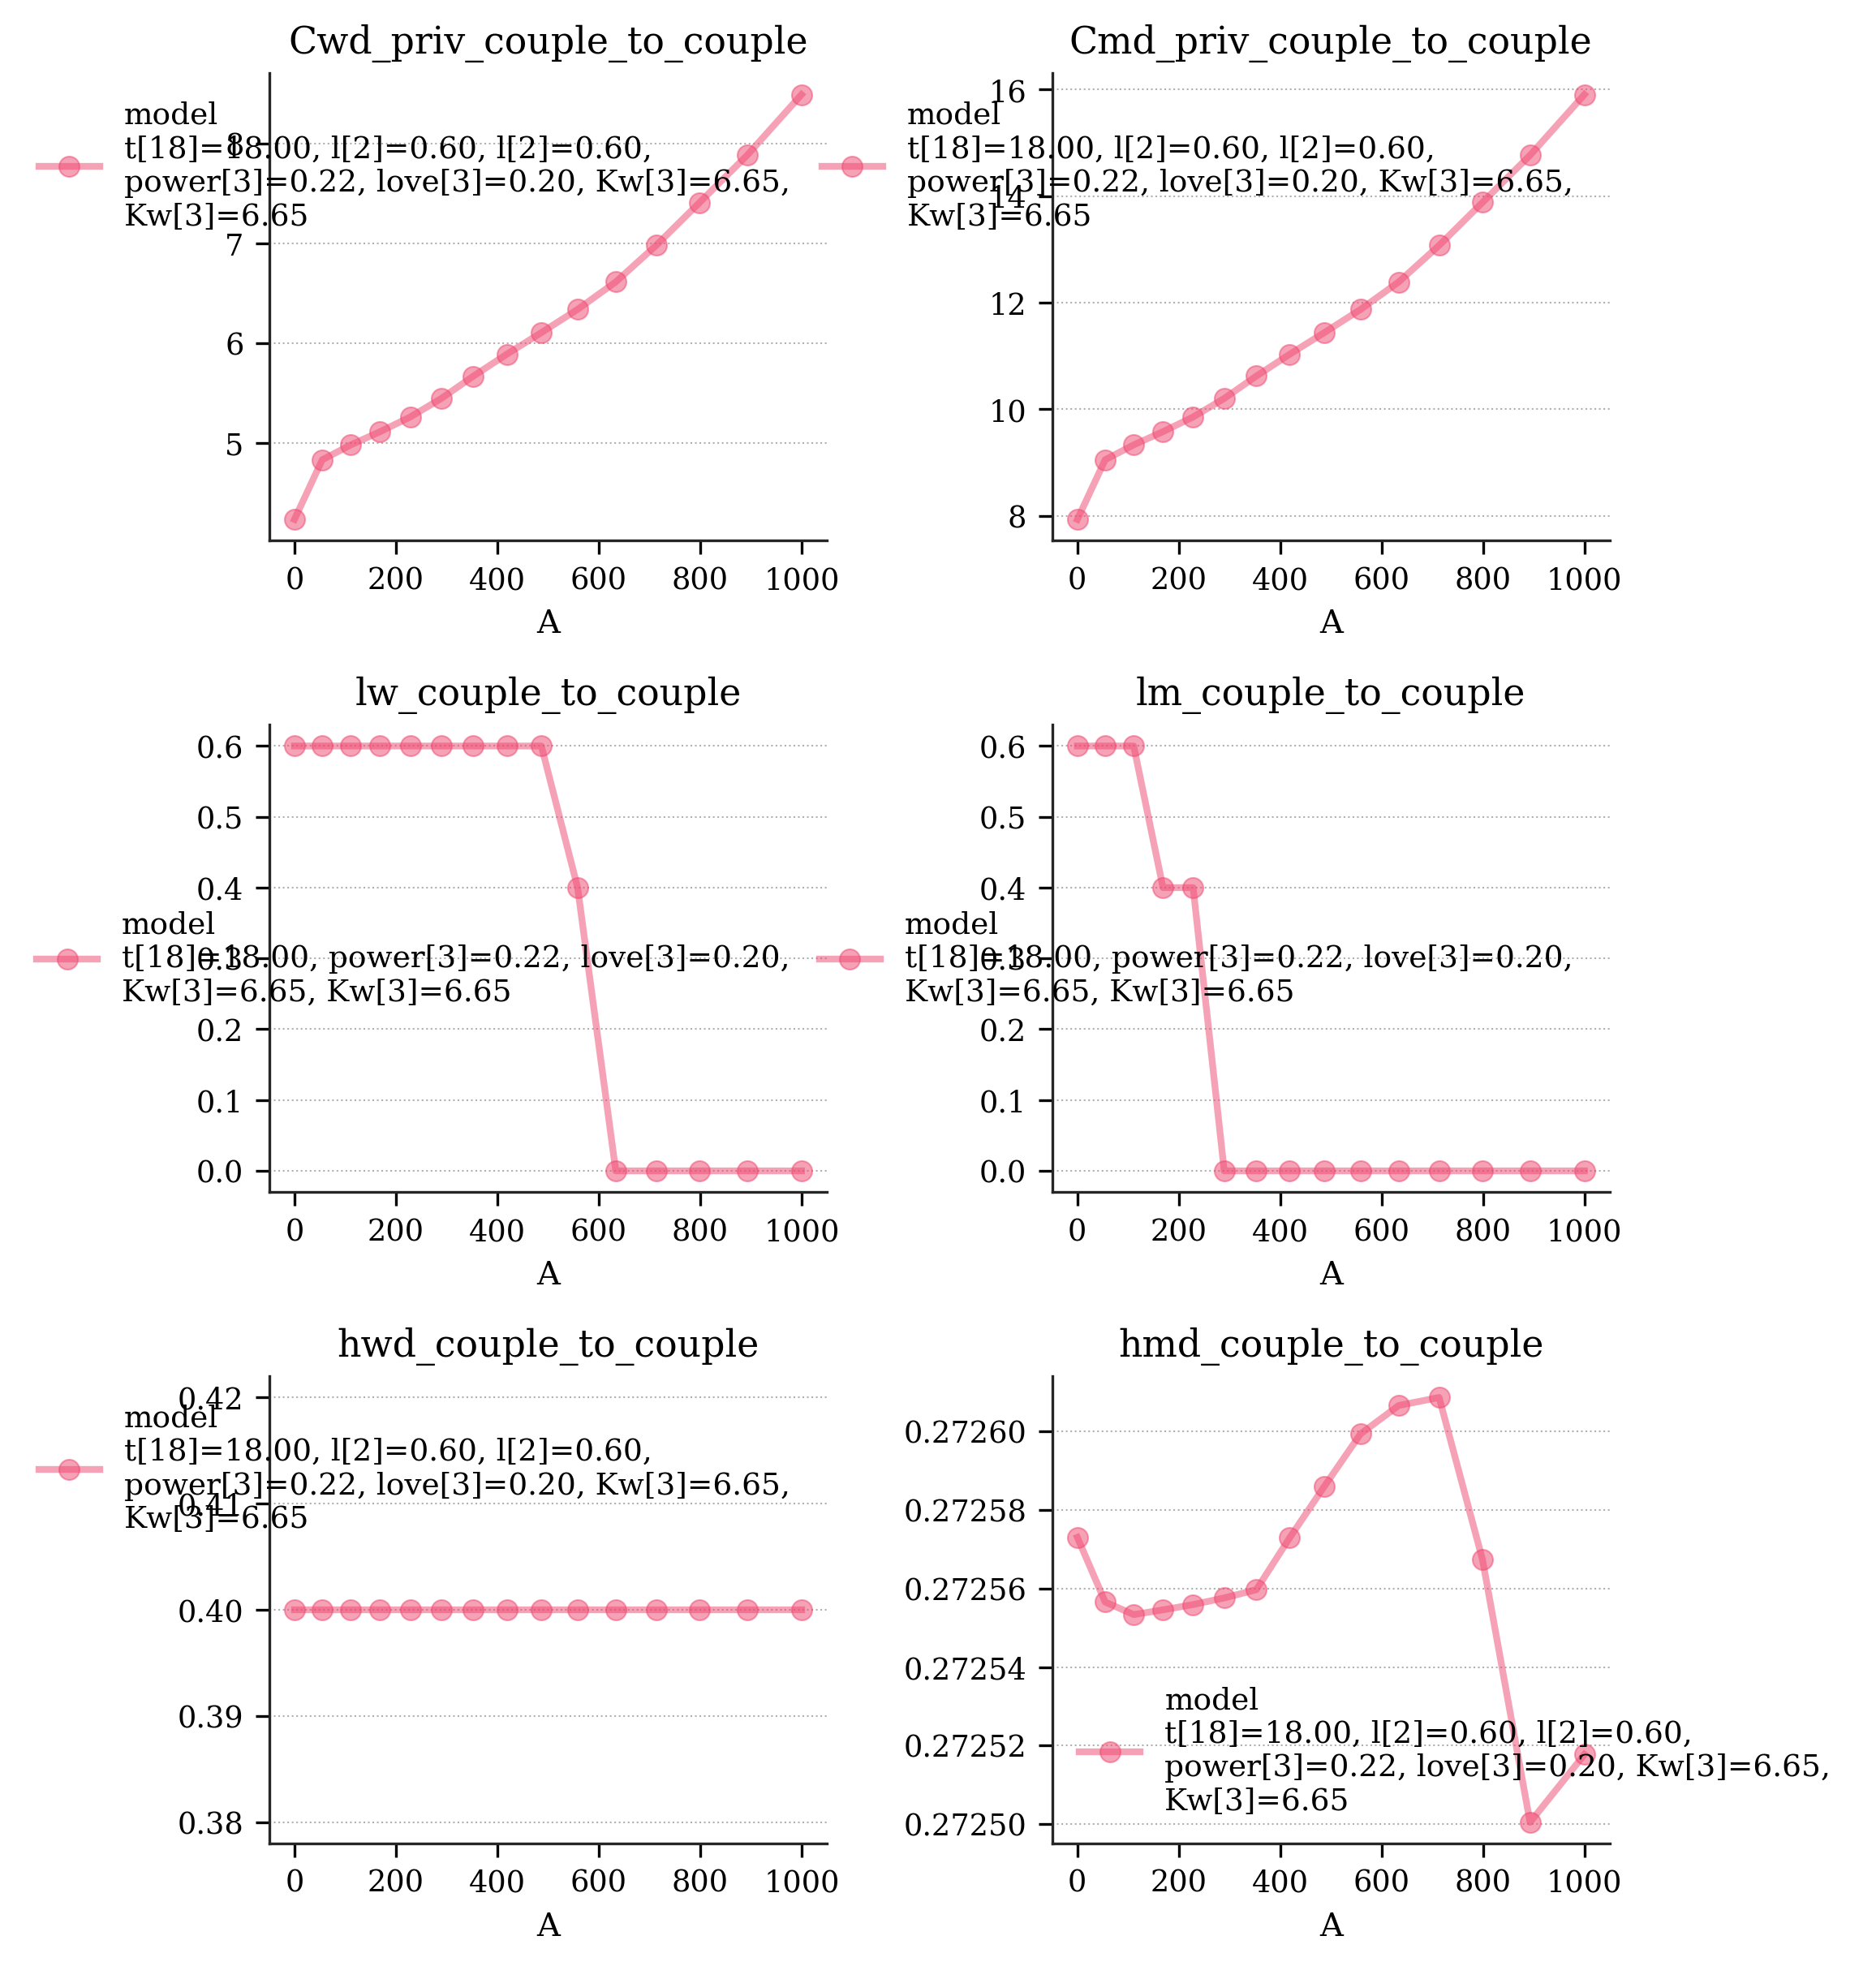

In [8]:
from plots import *

grid = 'grid_A'
idx = {'t': 18, 'il':2, 'iK': 3, 'iP': 3, 'iL': 3, 'iA': 10, 'iA_pd': 10}

mp = model_plotter(model, model_name='model', titles=['variable'], labels=['model', 'index'])
fig, ax = fm.create_figure(3,2,6)
mp.plot_gender_couple_choices(ax, grid=grid, index=idx, alpha=0.5)
fig.tight_layout()

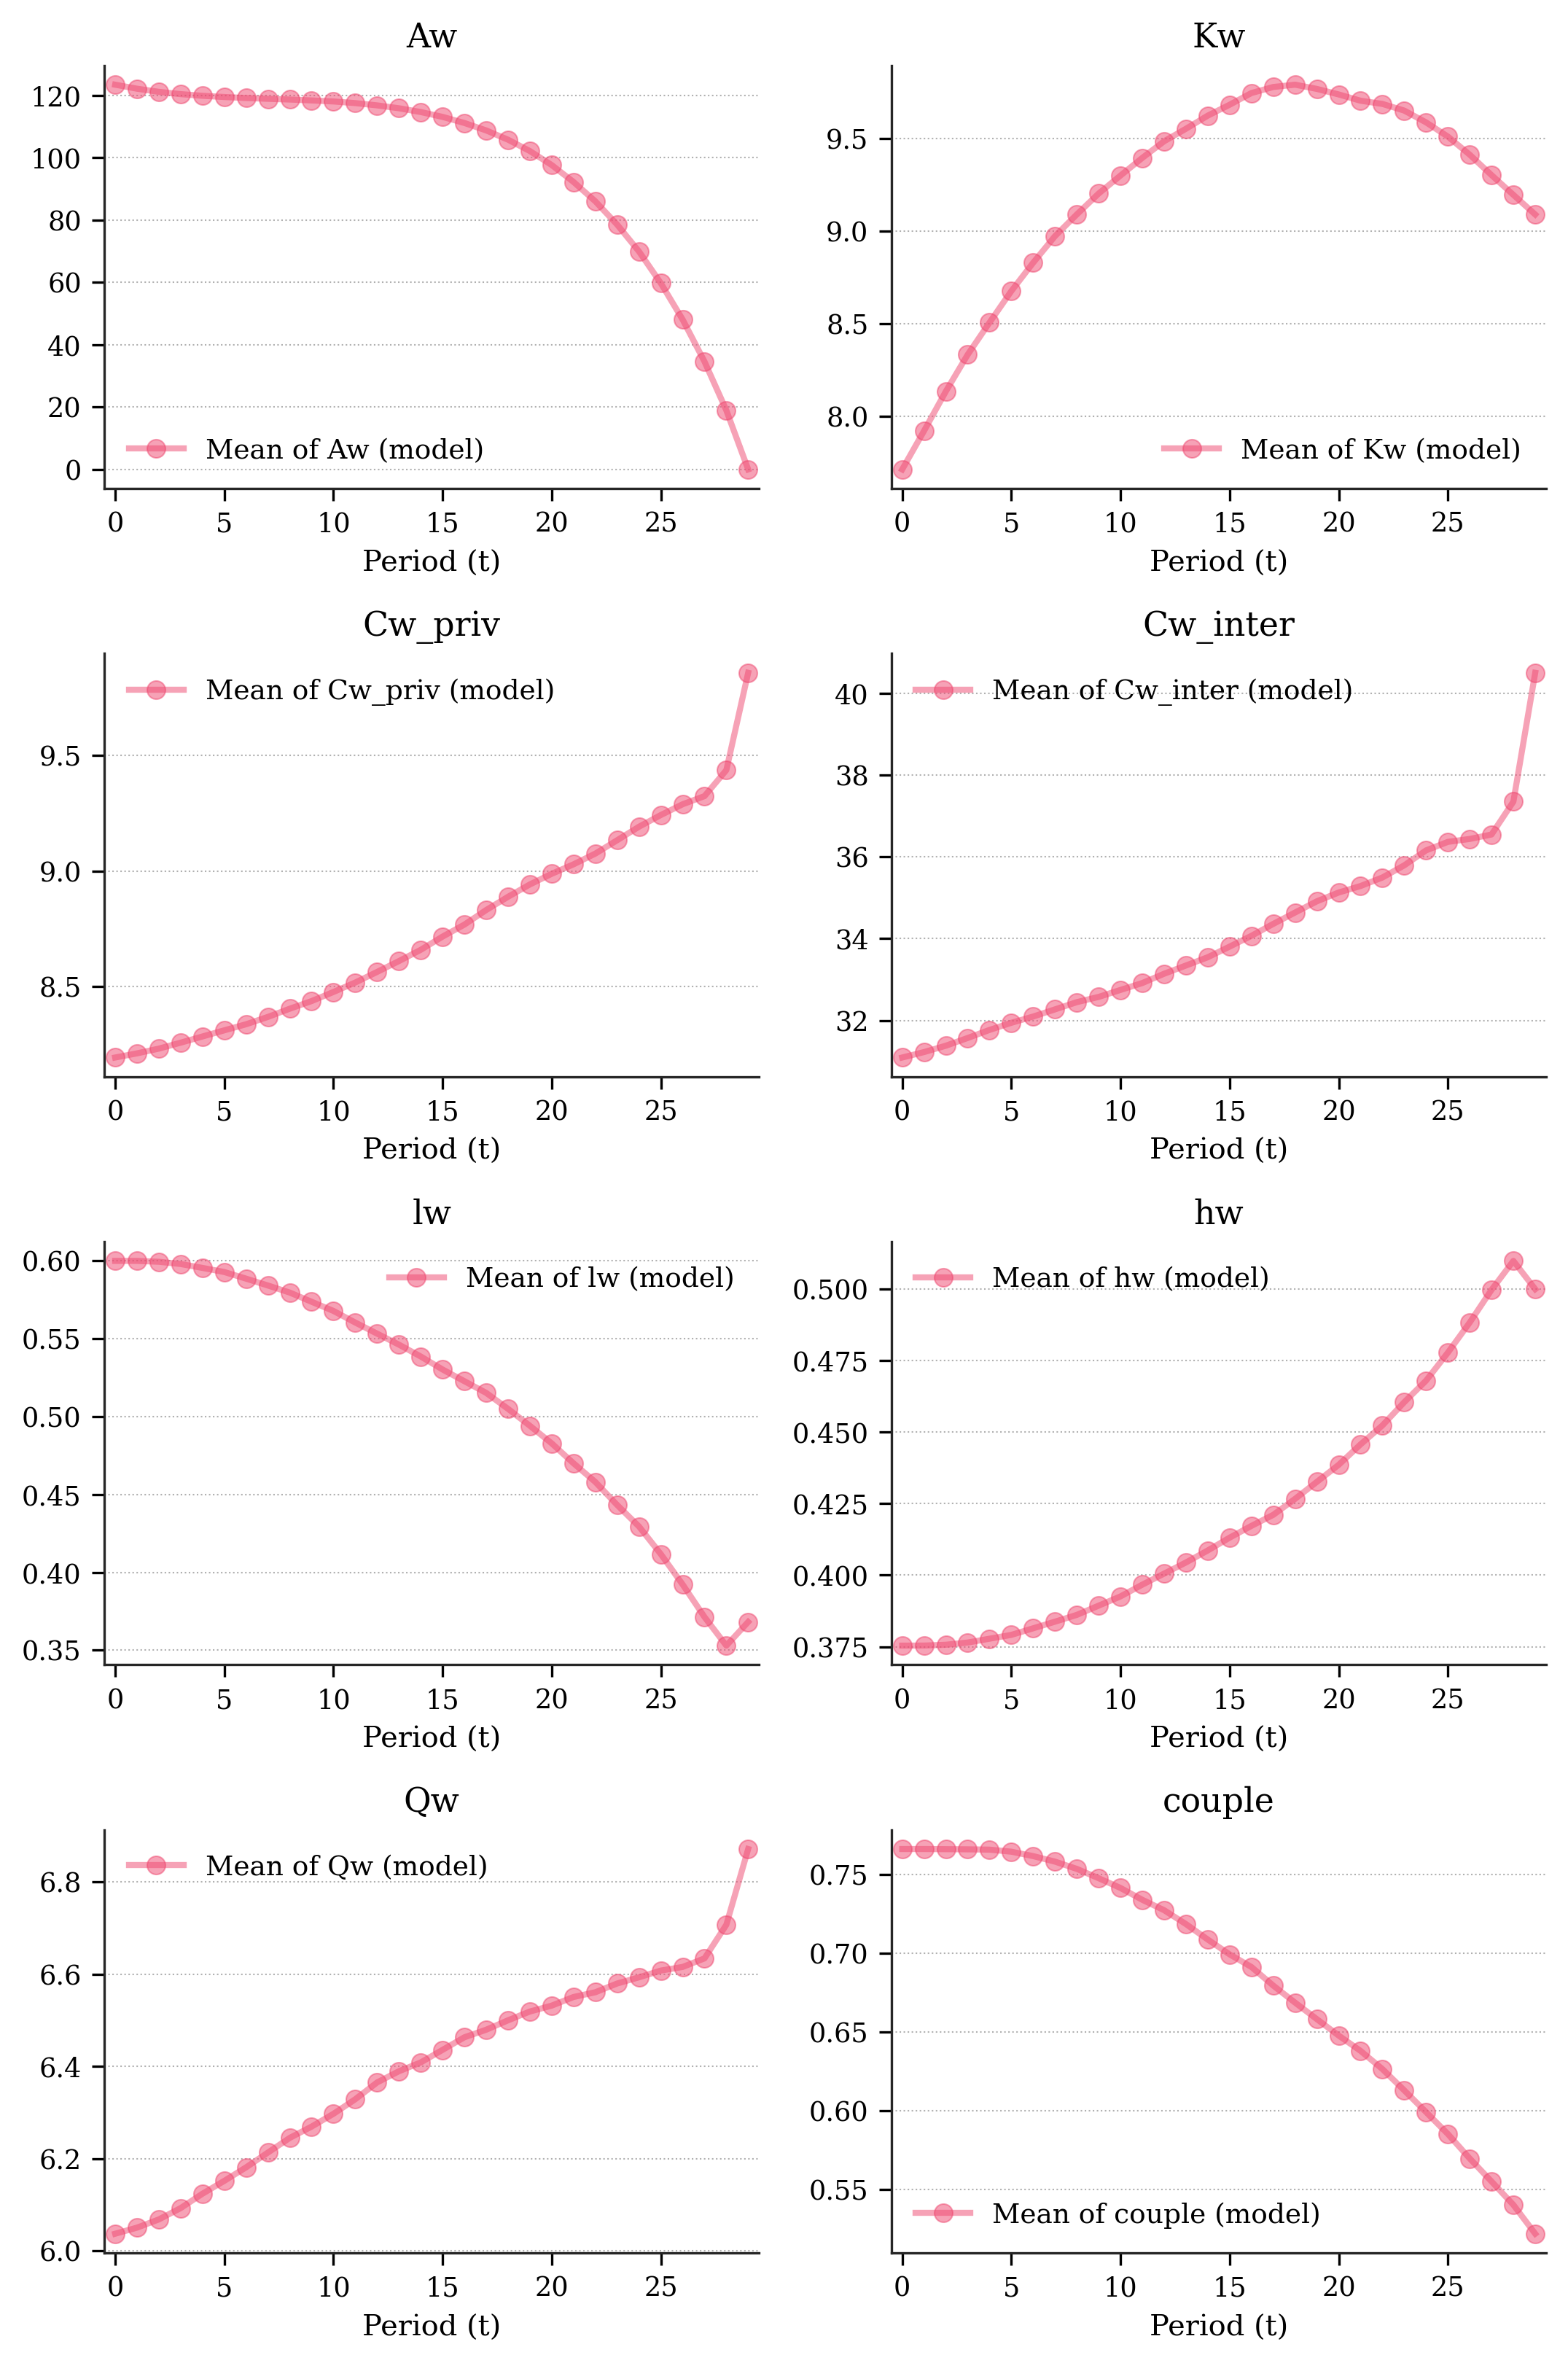

In [9]:
fig, ax = fm.create_figure(4,2,8)
mp.plot_sim_female(ax, alpha=0.5)
fig.tight_layout()

## Estimate model

In [ ]:
# Estimate model using nelder-mead algorithm
from scipy.optimize import minimize
do_print = True # Turn off... 
res = minimize(model.obj_func, theta_init, args=(estpars, datamoms,do_print), method='Nelder-Mead',
               options={'xatol': 1e-4, 'fatol': 1e-4, 'disp': True, 'maxiter':5000})


Parameters:
  mu             : 2.5000 (init: 2.5000)
  mu_mult        : 1.0000 (init: 1.0000)
  gamma          : 0.1200 (init: 0.1200)
  gamma_mult     : 1.0000 (init: 1.0000)
  eta            : 0.5000 (init: 0.5000)
  eta_mult       : 1.0000 (init: 1.0000)
  phi            : 0.7000 (init: 0.7000)
  phi_mult       : 1.0000 (init: 1.0000)
  alpha          : 1.0000 (init: 1.0000)
  zeta           : 0.5000 (init: 0.5000)
  omega          : 0.5000 (init: 0.5000)
  sigma_love     : 0.1500 (init: 0.1500)
  div_cost       : 0.0000 (init: 0.0000)
Moments:
  wage_level_w_25_34       : sim: 37.2630, data: 40.1000
  wage_level_m_25_34       : sim: 37.2933, data: 49.3000
  wage_level_w_35_44       : sim: 44.5378, data: 50.4000
  wage_level_m_35_44       : sim: 44.5812, data: 67.8000
  employment_rate_w_35_44  : sim: 88.0597, data: 64.0000
  employment_rate_m_35_44  : sim: 87.5246, data: 88.0000
  work_hours_w             : sim: 2434.1851, data: 1935.0000
  work_hours_m             : sim: 2434.5817